### RQ2. Testing Effectiveness (Fail/Pass Distinguishment)

In [1]:
import gc
import json
import os
import json
import torch
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from tqdm import tqdm
from collections import defaultdict

from matplotlib import colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from adjustText import adjust_text

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from scipy.stats import rankdata, pearsonr
from sklearn.metrics import roc_auc_score

from analysis_utils import calculate_pearson_correlation, convert_prob_to_descrete_labels, load_input_hidden_states, get_test_results, target_testsuites, prompt_templates, convert_to_normalized_rank_score

from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(["science", "grid", "nature"])

cmap = LinearSegmentedColormap.from_list("red_green", ["red", "green"], N=11)

task_alias_map = {
    "syntactic_bug_detection": "SYN-BUG",
    "spell_check": "SPELL-CHK",
    "github_typo_check": "GH-TYPO",
    "json_repair": "JSON-FIX",
    "pos_detection": "POS-TAG",
    "topic_classification": "TOPIC-CLS",
    "adding_odd_numbers": "ODD-ADD",
    "model_name_extraction": "MODEL-EX",
}

In [ ]:
refset_sizes = [100, 200, 300, 400, 500]

model = 'llama'
target_layer_map = {
    'llama': 21,
    'gemma': 28,
    'mistral': 22
}

plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
})

NUM_INITIAL_TESTS = 10
NUM_RANDOM_SEEDS = 10

result_suffix = f"_{model}"
target_iterations = [size // 10 for size in refset_sizes]

def load_individual_run_result(task, target_method, seed, num_reference, target_llm='llama', omit_references=True):
    result_suffix = f"_{target_llm}" if target_llm != 'llama' else ''
    target_layer = target_layer_map[target_llm]
    
    task_result_df = pd.read_pickle('../experiments/results_GMM/LIH_refset_iter_10{}/{}/layer_{}_seed_{}/{}_pca.pkl'.format(result_suffix, task, target_layer, seed, target_method))
    target_iteration_df = task_result_df[task_result_df['iteration'] == num_reference // 10].copy()
    
    target_indices = sorted(target_iteration_df.input_index.tolist())[:-NUM_INITIAL_TESTS]
    target_iteration_df = target_iteration_df[target_iteration_df['input_index'].isin(target_indices)] # Omit initial tests

    if omit_references:
        return target_iteration_df[target_iteration_df['label'] != 'ref']
    else:
        return target_iteration_df
    
def load_baseline_OOD_run_result(task, seed, num_reference, target_llm='llama', omit_references=True):
    result_suffix = f"_{target_llm}" if target_llm != 'llama' else ''
    target_layer = target_layer_map[target_llm]
    
    task_result_df = pd.read_pickle(f'../clotho/results{result_suffix}/{task}/precalculated_metrics/LIH_unweighted_SA_refset_layer_{target_layer}_10_0.5.pkl')
    target_iteration_df = task_result_df[(task_result_df['reference_set_size'] == num_reference) & (task_result_df['seed'] == seed)].copy()
    if omit_references:
        return target_iteration_df[target_iteration_df['label'] != 'ref']
    else:
        return target_iteration_df

100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


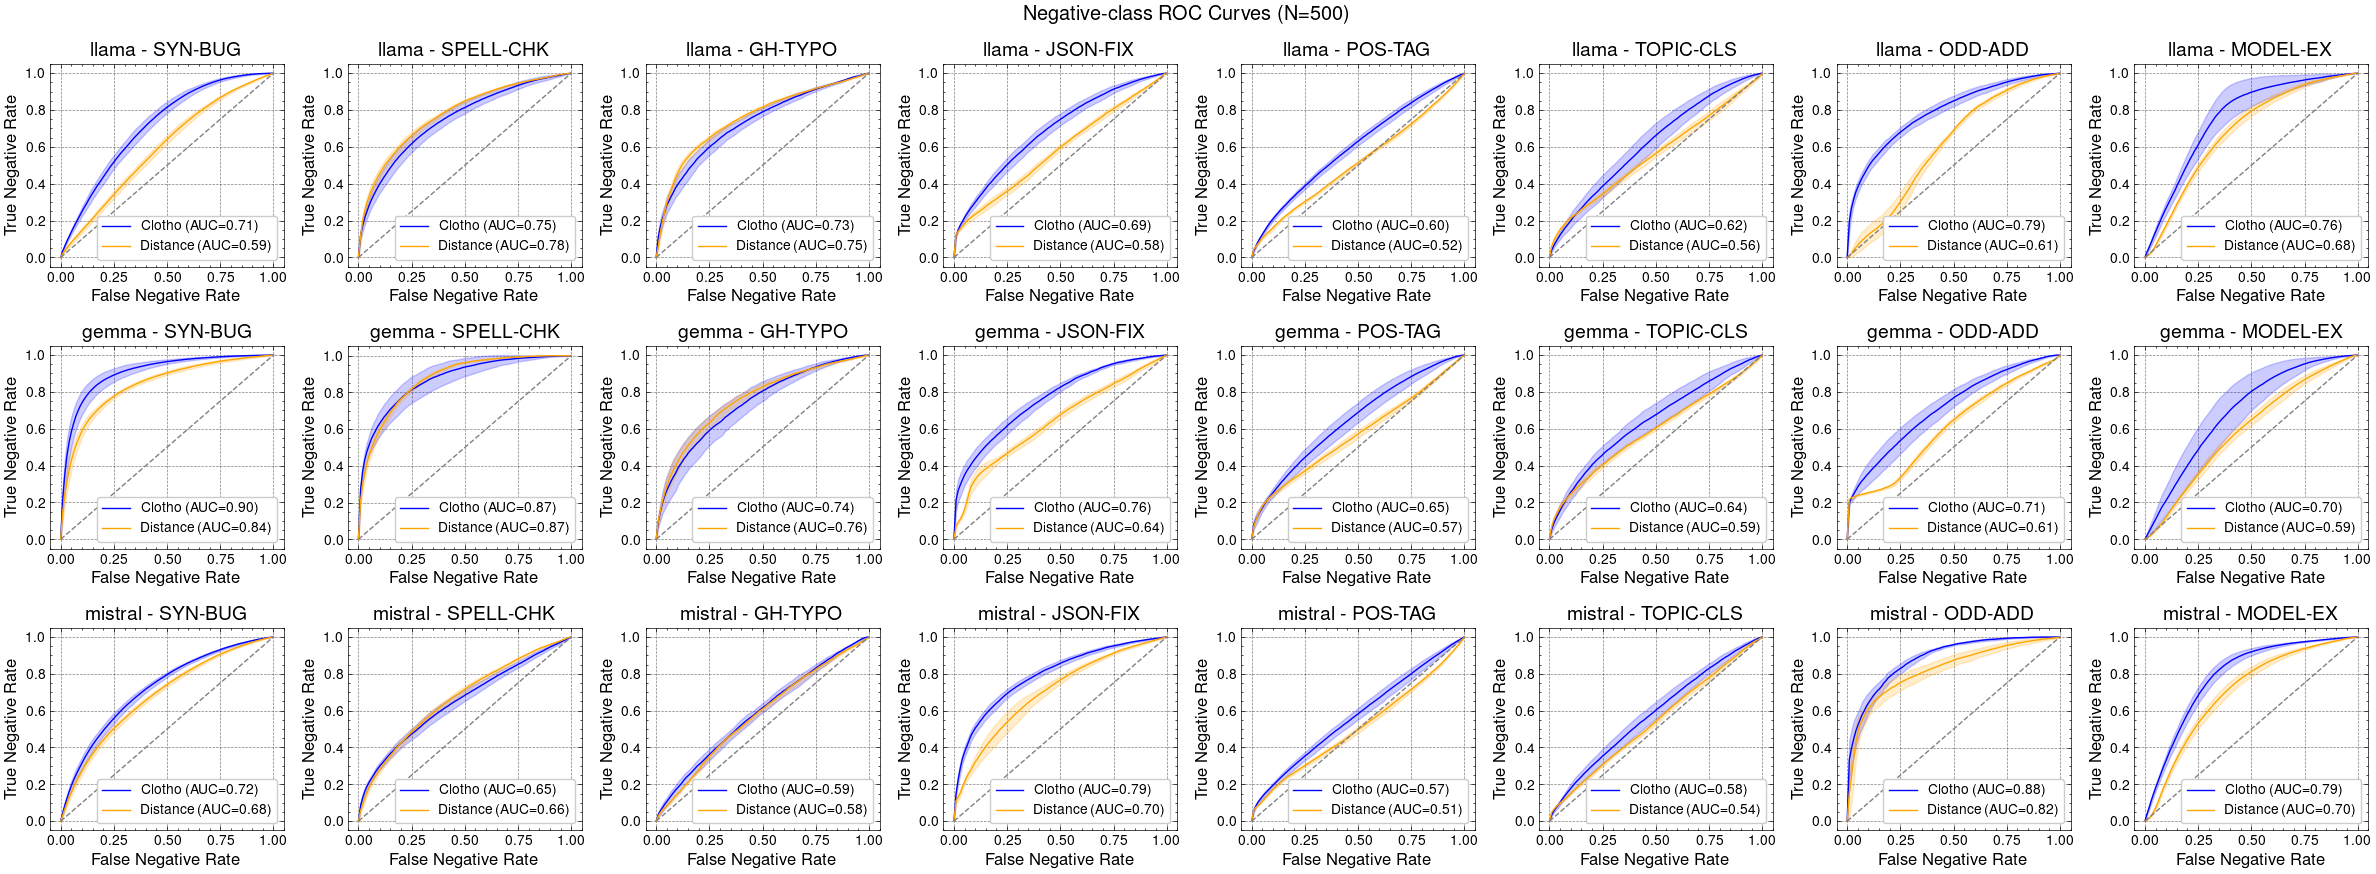

In [3]:
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.interpolate import interp1d

seeds = range(10)
target_method = "balanced"
num_reference = 500
target_llms = ['llama', 'gemma', 'mistral']

fig, axes = plt.subplots(len(target_llms), len(target_testsuites), figsize=(3 * len(target_testsuites), 3 * len(target_llms)))

for j, target_llm in enumerate(target_llms):
    for i, task in enumerate(tqdm(target_testsuites)):
        fnr_grid = np.linspace(0, 1, 100)
        tnr_all = defaultdict(list)
        auc_list = defaultdict(list)
        
        for seed in seeds:
            df = load_individual_run_result(task, target_method, seed, num_reference, target_llm=target_llm, omit_references=True)

            y = convert_prob_to_descrete_labels(df['test_score'].to_numpy(),
                                                binarize=True, binarize_choice='majority_pass')
            pred_score = df['logprob'].to_numpy()

            fpr, tpr, _ = roc_curve(y, pred_score, pos_label=1)

            fnr = 1 - tpr
            tnr = 1 - fpr

            interp_tnr = interp1d(fnr, tnr, kind='linear',
                                bounds_error=False, fill_value=(0,1))
            tnr_all['Clotho'].append(interp_tnr(fnr_grid))
            auc = roc_auc_score(y, pred_score)
            auc_list['Clotho'].append(auc)
            
            # Baseline (MDSA)
            df_baseline = load_baseline_OOD_run_result(task, seed, num_reference, target_llm=target_llm, omit_references=True)

            y = convert_prob_to_descrete_labels(df_baseline['test_score'].to_numpy(),
                                                binarize=True, binarize_choice='majority_pass')
            pred_score = -df_baseline['pred_score_MDSA'].to_numpy()
            fpr, tpr, _ = roc_curve(y, pred_score, pos_label=1)
            
            fnr = 1 - tpr
            tnr = 1 - fpr
            
            interp_tnr = interp1d(fnr, tnr, kind='linear',
                                bounds_error=False, fill_value=(0,1))
            tnr_all['Distance'].append(interp_tnr(fnr_grid))
            auc = roc_auc_score(y, pred_score)
            auc_list['Distance'].append(auc)

        for method in tnr_all:
            tnr_all[method] = np.array(tnr_all[method])
        
            tnr_mean = tnr_all[method].mean(axis=0)
            tnr_std = tnr_all[method].std(axis=0)

            auc_mean = np.mean(auc_list[method])
            auc_std = np.std(auc_list[method])
            
            color = "blue" if method == "Clotho" else "orange"

            axes[j, i].plot(fnr_grid, tnr_mean, color=color, label=f"{method} (AUC={auc_mean:.2f})")
            axes[j, i].fill_between(fnr_grid, tnr_mean - tnr_std, tnr_mean + tnr_std,
                        color=color, alpha=0.2)

        axes[j, i].plot([0,1],[0,1],'--', color="gray")
        axes[j, i].set_xlabel("False Negative Rate")
        axes[j, i].set_ylabel("True Negative Rate")
        axes[j, i].set_title(f"{target_llm} - {task_alias_map[task]}")
        axes[j, i].legend(loc='lower right')
        axes[j, i].grid(True)
        
fig.suptitle(f"Negative-class ROC Curves (N={num_reference})")
fig.tight_layout()
os.makedirs('./figures/rq2', exist_ok=True)
fig.savefig('./figures/rq2/neg_roc_auc_{}.png'.format(model))
fig.savefig('./figures/rq2/neg_roc_auc_{}.pdf'.format(model))
fig.show()

### Mann-Whitney U Test

In [5]:
from scipy.stats import mannwhitneyu
from sklearn.metrics import precision_recall_curve
import numpy as np

seeds = range(10)
stat_test_rows = []

methods = ['Distance', 'Clotho']

for i, task in enumerate(tqdm(target_testsuites)):
    for j, target_llm in enumerate(target_llms):
        for seed in seeds:
            for method in methods:
                if method == 'Clotho':
                    df = load_individual_run_result(task, target_method, seed, num_reference, target_llm=target_llm, omit_references=True)
                    y = 1 - convert_prob_to_descrete_labels(df['test_score'].to_numpy(),
                                                binarize=True, binarize_choice='majority_pass')
                    pred_score = -df['logprob'].to_numpy()
                    
                elif method == 'Distance':
                    df = load_baseline_OOD_run_result(task, seed, num_reference, target_llm=target_llm, omit_references=True)

                    y = 1 - convert_prob_to_descrete_labels(df['test_score'].to_numpy(),
                                                binarize=True, binarize_choice='majority_pass')
                    pred_score = df['pred_score_MDSA'].to_numpy()

                auc = roc_auc_score(y, pred_score)
                
                scores_pass = pred_score[y == 1]
                scores_fail = pred_score[y == 0]

                stat, p_value = mannwhitneyu(scores_fail, scores_pass, alternative='less')

                stat_test_rows.append({
                    'method': method,
                    'task': task,
                    'seed': seed,
                    'auc': auc,
                    'statistic': stat,
                    'p_value': p_value,
                    'target_llm': target_llm
                })


stat_df = pd.DataFrame(stat_test_rows)
stat_df

100%|██████████| 8/8 [00:19<00:00,  2.39s/it]


,method,task,seed,auc,statistic,p_value,target_llm
0,Distance,syntactic_bug_detection,0,0.589436,36776704.5,1.301155e-95,llama
1,Clotho,syntactic_bug_detection,0,0.712174,25766739.5,0.000000e+00,llama
2,Distance,syntactic_bug_detection,1,0.604554,35425106.5,7.538982e-130,llama
3,Clotho,syntactic_bug_detection,1,0.715413,25474915.0,0.000000e+00,llama
4,Distance,syntactic_bug_detection,2,0.566975,38777272.5,1.497753e-54,llama
...,...,...,...,...,...,...,...
475,Clotho,model_name_extraction,7,0.781873,4736235.5,0.000000e+00,mistral
476,Distance,model_name_extraction,8,0.700341,6517951.5,1.898187e-246,mistral
477,Clotho,model_name_extraction,8,0.793688,4479578.5,0.000000e+00,mistral
478,Distance,model_name_extraction,9,0.678783,6986931.5,9.360680e-197,mistral


In [10]:
stat_df.groupby(['method', 'target_llm', 'task'])[['auc']].mean().reset_index().pivot(index='method', columns=['target_llm', 'task'], values='auc')

target_llm              gemma                                \
task       adding_odd_numbers github_typo_check json_repair   
method                                                        
Clotho               0.714316          0.736848    0.763522   
Distance             0.609141          0.756321    0.641908   

target_llm                                                  \
task       model_name_extraction pos_detection spell_check   
method                                                       
Clotho                  0.695940      0.647628    0.868688   
Distance                0.594579      0.568397    0.871421   

target_llm                                                           llama  \
task       syntactic_bug_detection topic_classification adding_odd_numbers   
method                                                                       
Clotho                    0.904822             0.639564           0.789989   
Distance                  0.836155             0.587919           0.608891   

target_llm                    ...                          \
task       github_typo_check  ... syntactic_bug_detection   
method                        ...                           
Clotho              0.730899  ...                0.713813   
Distance            0.754023  ...                0.593348   

target_llm                                 mistral                    \
task       topic_classification adding_odd_numbers github_typo_check   
method                                                                 
Clotho                 0.618133           0.882550          0.587145   
Distance               0.557232           0.823422          0.575341   

target_llm                                                              \
task       json_repair model_name_extraction pos_detection spell_check   
method                                                                   
Clotho        0.792913              0.788047      0.570576    0.648808   
Distance      0.702349              0.702272      0.508128    0.663183   

target_llm                                               
task       syntactic_bug_detection topic_classification  
method                                                   
Clotho                    0.717234             0.580017  
Distance                  0.678582             0.539290  

[2 rows x 24 columns]

In [13]:
auc_stat_summary = stat_df.groupby(['target_llm', 'method'])[['auc']].agg(['mean', 'std'])
display(auc_stat_summary)

for model in ['gemma', 'llama', 'mistral']:
    for method in ['Clotho', 'Distance']:
        print('({}, {}): {:.3f} $\pm$ {:.2f} '.format(
            model,
            method,
            *auc_stat_summary.loc[(model, method), 'auc'].values
        ))

auc          
                         mean       std
target_llm method                      
gemma      Clotho    0.746416  0.099878
           Distance  0.683230  0.114051
llama      Clotho    0.706308  0.069045
           Distance  0.634022  0.089494
mistral    Clotho    0.695911  0.112184
           Distance  0.649071  0.098318

(gemma, Clotho): 0.746 $\pm$ 0.10 
(gemma, Distance): 0.683 $\pm$ 0.11 
(llama, Clotho): 0.706 $\pm$ 0.07 
(llama, Distance): 0.634 $\pm$ 0.09 
(mistral, Clotho): 0.696 $\pm$ 0.11 
(mistral, Distance): 0.649 $\pm$ 0.10 


In [29]:
# Average AUC of Clotho across all three models
print((auc_stat_summary.loc['gemma', 'Clotho'].auc[0] + auc_stat_summary.loc['llama', 'Clotho'].auc[0] + auc_stat_summary.loc['mistral', 'Clotho'].auc[0]) / 3)

0.7162116925228418


In [32]:
# Average AUC of Distance across all three models
print((auc_stat_summary.loc['gemma', 'Distance'].auc[0] + auc_stat_summary.loc['llama', 'Distance'].auc[0] + auc_stat_summary.loc['mistral', 'Distance'].auc[0]) / 3)

0.6554410542161268


In [34]:
# Percentage of reference inputs (500) among all studied dataset
percentages = []

for task in tqdm(target_testsuites):
    inference_results, _, test_scores = get_test_results('llama', task)
    percentages.append(500 / len(inference_results))
    
print(percentages)
np.mean(percentages) * 100

100%|██████████| 8/8 [00:15<00:00,  1.88s/it]

[0.024368846866166295, 0.05, 0.05, 0.07618467164406521, 0.032554202747574715, 0.06578947368421052, 0.08333333333333333, 0.0509683995922528]


np.float64(5.414986598345036)

In [38]:
summary_df = (
    stat_df.groupby(["method", "target_llm", "task"])
    .agg(
        auc_mean=("auc", "mean"),
        auc_std=("auc", "std"),
        p_mean=("p_value", "mean"),
        p_std=("p_value", "std"),
    )
    .reset_index()
)

summary_df["AUC"] = summary_df.apply(
    lambda r: f"{r.auc_mean:.3f} ± {r.auc_std:.2f}", axis=1
)
summary_df["p-value (Mann-Whitney)"] = summary_df.apply(
    lambda r: f"{r.p_mean:.1e}", axis=1
)
summary_df['Task ID'] = summary_df['task'].map(task_alias_map)
summary_df = summary_df[["method", "target_llm", "Task ID", "AUC", "p-value (Mann-Whitney)"]]

task_order = ['ODD-ADD', 'GH-TYPO', 'JSON-FIX', 'MODEL-EX', 'POS-TAG','SPELL-CHK','SYN-BUG', 'TOPIC-CLS']

df_ = summary_df.copy()
df_['Task ID'] = pd.Categorical(df_['Task ID'], categories=task_order, ordered=True)

summary_df_vis = (
    df_.pivot(index=['Task ID'], columns=['target_llm','method'],
              values=['AUC','p-value (Mann-Whitney)'])
      .sort_index(axis=1, level=[0,1], sort_remaining=True)
      .sort_index(axis=0)
display(summary_df_vis)
print(summary_df_vis.to_latex())

AUC                                            \
target_llm         gemma                       llama                 
method            Clotho      Distance        Clotho      Distance   
Task ID                                                              
ODD-ADD     0.714 ± 0.04  0.609 ± 0.01  0.790 ± 0.02  0.609 ± 0.02   
GH-TYPO     0.737 ± 0.05  0.756 ± 0.02  0.731 ± 0.02  0.754 ± 0.01   
JSON-FIX    0.764 ± 0.02  0.642 ± 0.01  0.690 ± 0.02  0.583 ± 0.01   
MODEL-EX    0.696 ± 0.07  0.595 ± 0.02  0.758 ± 0.05  0.684 ± 0.02   
POS-TAG     0.648 ± 0.04  0.568 ± 0.01  0.601 ± 0.02  0.516 ± 0.01   
SPELL-CHK   0.869 ± 0.04  0.871 ± 0.01  0.748 ± 0.03  0.776 ± 0.01   
SYN-BUG     0.905 ± 0.02  0.836 ± 0.01  0.714 ± 0.02  0.593 ± 0.01   
TOPIC-CLS   0.640 ± 0.04  0.588 ± 0.01  0.618 ± 0.04  0.557 ± 0.02   

                                       p-value (Mann-Whitney)            \
target_llm       mistral                                gemma             
method            Clotho      Distance                 Clotho  Distance   
Task ID                                                                   
ODD-ADD     0.883 ± 0.01  0.823 ± 0.03                2.4e-81   4.1e-34   
GH-TYPO     0.587 ± 0.02  0.575 ± 0.01               9.3e-105  1.2e-293   
JSON-FIX    0.793 ± 0.01  0.702 ± 0.02               4.6e-122   7.0e-45   
MODEL-EX    0.788 ± 0.02  0.702 ± 0.02                2.6e-36   2.8e-24   
POS-TAG     0.571 ± 0.02  0.508 ± 0.01                4.4e-41   1.4e-17   
SPELL-CHK   0.649 ± 0.02  0.663 ± 0.01               2.6e-186   0.0e+00   
SYN-BUG     0.717 ± 0.01  0.679 ± 0.01                0.0e+00   0.0e+00   
TOPIC-CLS   0.580 ± 0.03  0.539 ± 0.01                1.9e-29   3.2e-19   

                                                    
target_llm     llama             mistral            
method        Clotho  Distance    Clotho  Distance  
Task ID                                             
ODD-ADD     6.1e-254   2.3e-17  6.3e-117   6.5e-84  
GH-TYPO     5.6e-238   0.0e+00   2.4e-11   2.2e-23  
JSON-FIX     1.8e-73   8.0e-20  1.4e-253   7.7e-84  
MODEL-EX    6.3e-104  4.0e-141   0.0e+00  3.0e-183  
POS-TAG      2.6e-45   1.8e-02   1.7e-09   2.1e-01  
SPELL-CHK   2.4e-182  7.0e-266   1.9e-52   1.2e-96  
SYN-BUG      0.0e+00   1.5e-55   0.0e+00  4.8e-284  
TOPIC-CLS    4.8e-10   1.7e-06   2.0e-06   3.7e-04

\begin{tabular}{lllllllllllll}
\toprule
 & \multicolumn{6}{r}{AUC} & \multicolumn{6}{r}{p-value (Mann-Whitney)} \\
target_llm & \multicolumn{2}{r}{gemma} & \multicolumn{2}{r}{llama} & \multicolumn{2}{r}{mistral} & \multicolumn{2}{r}{gemma} & \multicolumn{2}{r}{llama} & \multicolumn{2}{r}{mistral} \\
method & Clotho & Distance & Clotho & Distance & Clotho & Distance & Clotho & Distance & Clotho & Distance & Clotho & Distance \\
Task ID &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
ODD-ADD & 0.714 ± 0.04 & 0.609 ± 0.01 & 0.790 ± 0.02 & 0.609 ± 0.02 & 0.883 ± 0.01 & 0.823 ± 0.03 & 2.4e-81 & 4.1e-34 & 6.1e-254 & 2.3e-17 & 6.3e-117 & 6.5e-84 \\
GH-TYPO & 0.737 ± 0.05 & 0.756 ± 0.02 & 0.731 ± 0.02 & 0.754 ± 0.01 & 0.587 ± 0.02 & 0.575 ± 0.01 & 9.3e-105 & 1.2e-293 & 5.6e-238 & 0.0e+00 & 2.4e-11 & 2.2e-23 \\
JSON-FIX & 0.764 ± 0.02 & 0.642 ± 0.01 & 0.690 ± 0.02 & 0.583 ± 0.01 & 0.793 ± 0.01 & 0.702 ± 0.02 & 4.6e-122 & 7.0e-45 & 1.8e-73 & 8.0e-20 & 1.4e-253 & 7.7e-84 \\
MODEL-EX & 0.696 ± 0.0